# 3. Biocellion Sensitivity Analysis - Analyze
This notebook defines functions to run and plot sensitivity analysis after sampling the parameter space and running simulations for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  


In [1]:
import matplotlib.pyplot as plt
import paraview.simple as pvs
import pandas as pd
import numpy as np
import math
import json

from pathlib import Path
from SALib.analyze.morris import analyze as morris_analyze

from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, \
    sample_histograms

import os
import re
from datetime import datetime
import xml.etree.ElementTree as ET
from itertools import chain

## User settings

In [2]:
# Set this data dir to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_DIR = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-data/PLOSone_ABM-CFD-microcarrier")
MODEL_DIR = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/ABM-microcarriers")
TOOLS_DIR = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/biocellion-tools")
FIG_DIR = Path("./figures")

In [3]:
SEED = 20190605  # TODO, get seed from (to be) generated sample file

## Run Elementary Effects sensitivity analysis
After running the simulations for the sampled input parameters we can analyze its output using the Elementary Effects method, also called Morris method. For more information on this method see [Morris 1991](http://www.tandfonline.com/doi/abs/10.1080/00401706.1991.10484804) and [Campolongo et al. 2007](http://www.sciencedirect.com/science/article/pii/S1364815206002805). We use the package SALib that implements this and other methods along with various helper function. For more information on SALib see [the documentation](https://salib.readthedocs.io/en/latest/).

In [80]:
class Analysis:
    def __init__(self, model_output_base_dir, output_specs = None, seed=None):
        self.model_output_base_dir = model_output_base_dir
        self.output_specs = output_specs
        
        self.model_output = None
        self.output_location = None
        self.timestamp = None
        self.sa_output = None
        self.sa_output_path = None
        self.problem = None
        
        self.model_output_timestamp = self.model_output_base_dir.name[-15:]
        self.sa_output_dir = model_output_base_dir / f"SA_{self.timestamp}"
        self._set_timestamp()
        
        
    def _set_timestamp(self):
        self.init_time = datetime.now()
        self.timestamp = self.init_time.strftime("%Y%m%d-%H%M%S")


    def _get_param_sample(self):
        """Get parameter list and the problem formulation."""
        param_sample_filename = self.model_output_base_dir / f"parameter_sample_{self.model_output_timestamp}.csv"
        param_sample = pd.read_csv(param_sample_filename, index_col=0)
        return param_sample.to_numpy()
        
        
    def _get_problem(self):
        param_info_filename = self.model_output_base_dir / f"parameter_info_{self.model_output_timestamp}.csv"
        param_info = pd.read_csv(param_info_filename)
#         print(param_info)
        problem = {
          'num_vars': len(param_info),
          'names': param_info["name"].values.tolist(),
          'bounds': param_info[["range_min","range_max"]].values.tolist()
        }
        return problem
        
    def _get_single_output(self, filename, state, step):
        get_state = False
        with open(filename, 'r' ) as f :
            for line in f:
                if str(step) in line:
#                     print(line)
                    get_state=True
                if (state in line) and get_state:
#                     print(line)
                    value = int( line.strip().split(':')[-1] ) 
                    break
#         print(value)
        return value
        # if the lengths of these list are different print error

        
    def _get_model_outputs(self, state, step):
        model_outputs = np.array([])
#         print(model_outputs)
        for output_dir in sorted(self.model_output_base_dir.glob("output_*")):
            filename = output_dir / "output.log"
#             print(filename)
            model_outputs = np.append(model_outputs, self._get_single_output(filename, state, step))
        return model_outputs
        
        
    def run(self, at_step = 50000, state = "attached", seed=None):
        param_sample = self._get_param_sample()
        problem = self._get_problem()
        state_dict = {'live': 'Live Cells', 'attached': 'Live Attached Cells', 'dead': 'Death Cells', 'removed': 'Removed Cells'}
        model_outputs = self._get_model_outputs(state_dict[state], at_step)
        
        self.sa_output = morris_analyze(problem, param_sample, model_outputs, seed = seed)

        
    def plot(self):
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(18.5, 5)
        horizontal_bar_plot(ax[0], self.sa_output, {})
        covariance_plot(ax[1], self.sa_output, {})
        fig.savefig(FIG_DIR / f"SA_{self.model_output_timestamp}.png")
        
    

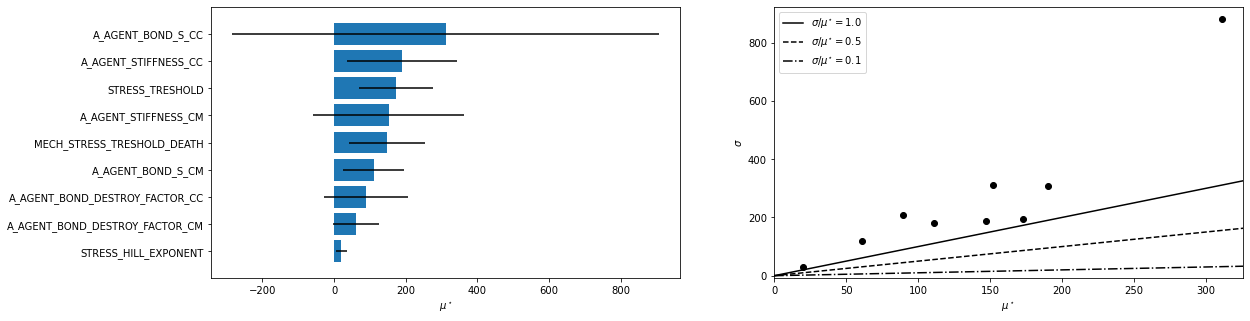

In [82]:
model_output_base_dir = MODEL_DIR / "output_20210604-175935"
analysis = Analysis(model_output_base_dir)
# analysis.get_model_output()
analysis.run(at_step = 50000, state="attached", seed = SEED)
analysis.plot()

In [42]:
df = pd.DataFrame()
results = analysis.sa_output
keys = results.keys()
results_df = df.from_dict(results)
results_df.sort_values("mu_star")

,names,mu,mu_star,sigma,mu_star_conf
0,STRESS_HILL_EXPONENT,12.30,20.10,29.049957,15.473749
8,A_AGENT_BOND_DESTROY_FACTOR_CM,5.70,60.90,119.814023,65.331459
5,A_AGENT_BOND_DESTROY_FACTOR_CC,-75.30,89.40,207.248402,116.280770
7,A_AGENT_BOND_S_CM,8.40,111.30,181.387982,85.145224
1,MECH_STRESS_TRESHOLD_DEATH,135.00,147.00,189.298706,106.128975
6,A_AGENT_STIFFNESS_CM,142.65,152.25,310.280075,209.988778
2,STRESS_TRESHOLD,161.85,172.95,193.609723,103.949523
3,A_AGENT_STIFFNESS_CC,-99.00,190.20,306.627624,153.399831
4,A_AGENT_BOND_S_CC,-237.00,311.40,881.053631,595.175044


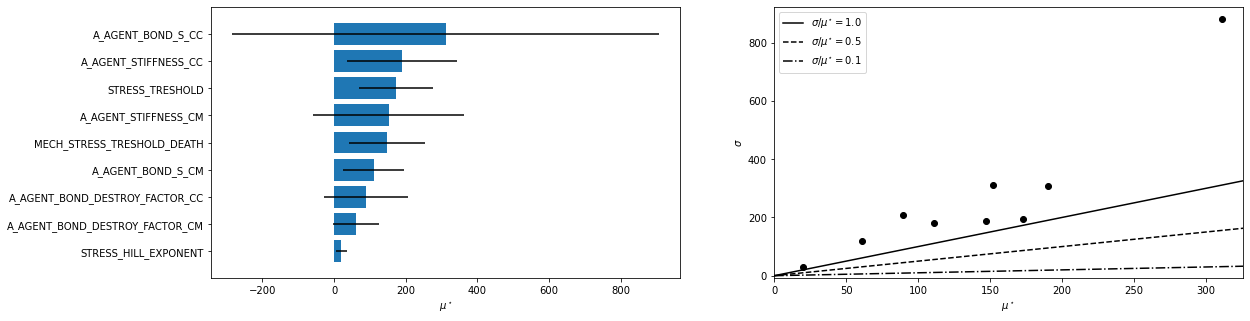

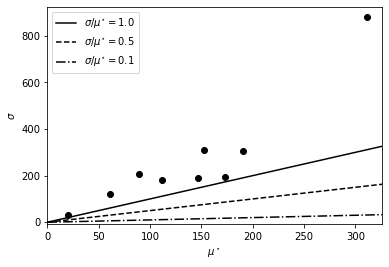